# Adaption to new classes
project 7 by Guanzhao Wang, Haochen Wu, Yukai Wang

### Abstact outline:
In this project, the goal is to find a way conbines unsupervised and supervised method. 

A classification model is trained under labelled categories on Fashion-MNIST dataset. Then, new categories are added without labels. There are several unsupervised clustering methods implemented and compared. The classification model will based on the pretrained model from supervised images and retrained with the categories labelled by the unsupervised methods.

### Teammates:
- Guanzhao Wang:

- Haochen Wu:

- Yukai Wang:

In [1]:
from mylibs.dataloader import getTrainValidateLoaders, getTestLoaders
from mylibs.train import train
from mylibs.eval import validate
from mylibs.model import Net, CustomFashionResNet
from mylibs.loss import loss_function
from mylibs.report import report_epoch_summary, report_summary
from mylibs.save import save, load

import torch
from torchvision import transforms
import os

In [2]:
USE_GPU = True
BATCH_SIZE = 64
EPOCH = 10
NUM_WORKERS = 2
K = 7

In [3]:
device = torch.device("cuda" if USE_GPU else "cpu")

transform = transforms.Compose([
    transforms.ToTensor()
])

mode_description = {0: "clustering: kmeans",
                    1: "clustering: kmeans with PCA",
                    2: "clustering: kmeans with Auto Encoder",
                    3: "clustering: Gaussian Mixture",
                    4: "clustering: Gaussian Mixture with PCA",
                    5: "clustering: Gaussian Mixture with Auto Encoder",
                    6: "use only labeled data",
                    7: "use full FasionMNIST data",
                   }

mode_description_short = {0: "Kmeans",
                          1: "Kmeans with PCA",
                          2: "Kmeans with Auto Encoder",
                          3: "Gaussian Mixture",
                          4: "Gaussian Mixture with PCA",
                          5: "Gaussian Mixture with Auto Encoder",
                          6: "Labeled data only",
                          7: "Full FasionMNIST",
                         }

mode_metrics = {}

In [4]:
def whole_flow(mode, useResnet):
    print(f"Getting train and validate dataloaders for mode {mode}: {mode_description[mode]}")
    train_val_loaders = getTrainValidateLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, split=0.9, num_workers=NUM_WORKERS, mode=mode, USE_GPU=USE_GPU)
    if useResnet:
        model = CustomFashionResNet(color_scale = 1, num_classes = 10).to(device)
    else:
        model = Net().to(device)
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01)
    eval_metrics = []

    model_name = "ResNet" if useResnet else "Net"
    checkpoint_path = f"./checkpoint/mode_{mode}/{model_name}"
    os.makedirs(checkpoint_path, exist_ok=True)
    
    print(f"Start Training... {model_name}")
    # scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, EPOCH+1):
        eval_metric = train(train_val_loaders, model, loss_function, optimizer, USE_GPU, f"{checkpoint_path}/epoch_{epoch}.pt")
        eval_metrics.append(eval_metric)
        print(f"Epoch: {epoch}")
        print(f"\tTrain      - Loss: {eval_metric['train']['loss']:.4f} Accuracy: {eval_metric['train']['acc']:.4f} F1_score: {eval_metric['train']['f1']:.4f}")
        print(f"\tValidation - Loss: {eval_metric['val']['loss']:.4f} Accuracy: {eval_metric['val']['acc']:.4f} F1_score: {eval_metric['val']['f1']:.4f}")

    report_epoch_summary(eval_metrics)
    
    all_val_f1 = [x['val']['f1'] for x in eval_metrics]
    best_epoch = all_val_f1.index(max(all_val_f1)) + 1
    print(f"Loading model at epoch {best_epoch} for best validation f1")
    checkpoint = torch.load(f"{checkpoint_path}/epoch_{epoch}.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    print("Preparing test loaders")
    labeled_test_loader, unlabeled_test_loader, test_loader = getTestLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, USE_GPU=USE_GPU)
    
    model.eval()
    eval_metric = validate(labeled_test_loader, model, loss_function, USE_GPU)
    print(f"Result on labelled test set  : Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

    eval_metric = validate(unlabeled_test_loader, model, loss_function, USE_GPU)
    print(f"Result on unlabelled test set: Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

    eval_metric = validate(test_loader, model, loss_function, USE_GPU)
    print(f"Result on full test set      : Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")
    
    return eval_metrics

## Baseline #1, use only first K-class labelled data to train

Getting train and validate dataloaders for mode 6: use only labeled data
Start Training... Net
Epoch: 1
	Train         - Loss: 0.5902 Accuracy: 0.7947 F1_score: 0.7917
	Validation    - Loss: 0.4569 Accuracy: 0.8264 F1_score: 0.8217
Epoch: 2
	Train         - Loss: 0.4074 Accuracy: 0.8529 F1_score: 0.8518
	Validation    - Loss: 0.4087 Accuracy: 0.8474 F1_score: 0.8420
Epoch: 3
	Train         - Loss: 0.3644 Accuracy: 0.8688 F1_score: 0.8680
	Validation    - Loss: 0.3819 Accuracy: 0.8583 F1_score: 0.8584
Epoch: 4
	Train         - Loss: 0.3369 Accuracy: 0.8782 F1_score: 0.8776
	Validation    - Loss: 0.3658 Accuracy: 0.8662 F1_score: 0.8647
Epoch: 5
	Train         - Loss: 0.3169 Accuracy: 0.8865 F1_score: 0.8859
	Validation    - Loss: 0.3490 Accuracy: 0.8707 F1_score: 0.8704
Epoch: 6
	Train         - Loss: 0.3020 Accuracy: 0.8918 F1_score: 0.8913
	Validation    - Loss: 0.3434 Accuracy: 0.8721 F1_score: 0.8706
Epoch: 7
	Train         - Loss: 0.2883 Accuracy: 0.8965 F1_score: 0.8960
	Validatio

<Figure size 432x288 with 0 Axes>

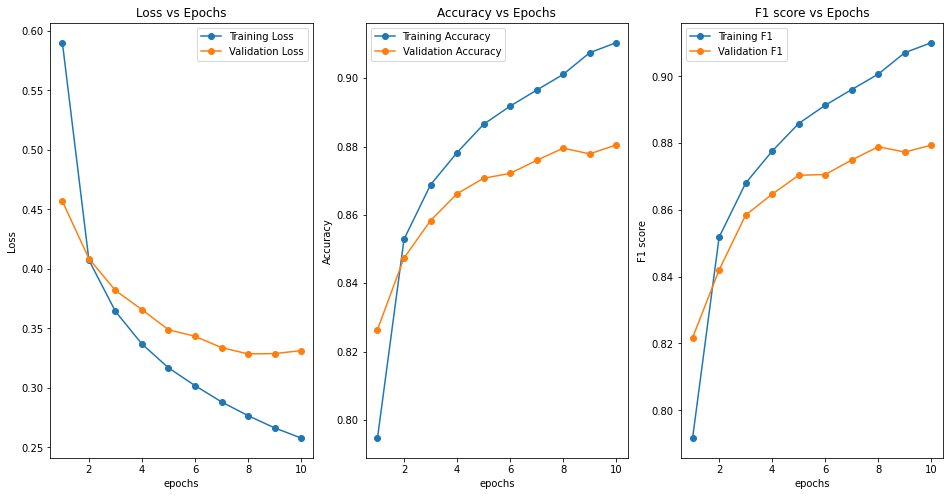

Loading model at epoch 10 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3485 Accuracy: 0.8680 F1_score: 0.8655
Result on unlabelled test set: Loss: 9.6321 Accuracy: 0.0000 F1_score: 0.0000
Result on full test set      : Loss: 3.1273 Accuracy: 0.6076 F1_score: 0.5233


In [5]:
mode_metric = whole_flow(6, False)
mode_metrics[6] = mode_metric

## Baseline #2, use full Fashion-MNIST dataset to train

Getting train and validate dataloaders for mode 7: use full FasionMNIST data
Start Training... Net
Epoch: 1
	Train         - Loss: 0.5435 Accuracy: 0.8204 F1_score: 0.8186
	Validation    - Loss: 0.4102 Accuracy: 0.8550 F1_score: 0.8543
Epoch: 2
	Train         - Loss: 0.3535 Accuracy: 0.8761 F1_score: 0.8753
	Validation    - Loss: 0.3729 Accuracy: 0.8665 F1_score: 0.8631
Epoch: 3
	Train         - Loss: 0.3121 Accuracy: 0.8909 F1_score: 0.8904
	Validation    - Loss: 0.3430 Accuracy: 0.8813 F1_score: 0.8797
Epoch: 4
	Train         - Loss: 0.2853 Accuracy: 0.9006 F1_score: 0.9003
	Validation    - Loss: 0.3294 Accuracy: 0.8865 F1_score: 0.8856
Epoch: 5
	Train         - Loss: 0.2660 Accuracy: 0.9076 F1_score: 0.9072
	Validation    - Loss: 0.3194 Accuracy: 0.8918 F1_score: 0.8908
Epoch: 6
	Train         - Loss: 0.2506 Accuracy: 0.9139 F1_score: 0.9136
	Validation    - Loss: 0.3109 Accuracy: 0.8922 F1_score: 0.8921
Epoch: 7
	Train         - Loss: 0.2375 Accuracy: 0.9171 F1_score: 0.9169
	Valid

<Figure size 432x288 with 0 Axes>

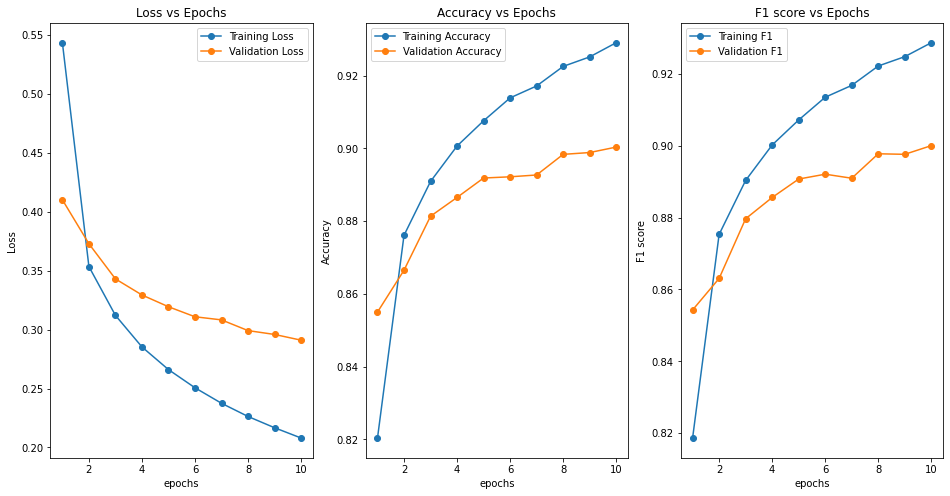

Loading model at epoch 10 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3599 Accuracy: 0.8696 F1_score: 0.8747
Result on unlabelled test set: Loss: 0.0972 Accuracy: 0.9677 F1_score: 0.9735
Result on full test set      : Loss: 0.2829 Accuracy: 0.8990 F1_score: 0.8989


In [6]:
mode_metric = whole_flow(7, False)
mode_metrics[7] = mode_metric

# Label new categories by clustering

- label the dataset under different clustering methods
- compare acuracy on the test set

## Approach #1, use KMeans to compute label for unlabelled data

## Approach #2, use KMeans with PCA to compute label for unlabelled data

In [ ]:
mode_metric = whole_flow(2, False)
mode_metrics[2] = mode_metric

## Approach #3, use KMeans with Auto Encoder to compute label for unlabelled data

## Approach #4, use Gaussian Mixture to compute label for unlabelled data

## Approach #5, use Gaussian Mixture with PCA to compute label for unlabelled data

## Approach #6, use Gaussian Mixture with Auto Encoder to compute label for unlabelled data

<Figure size 432x288 with 0 Axes>

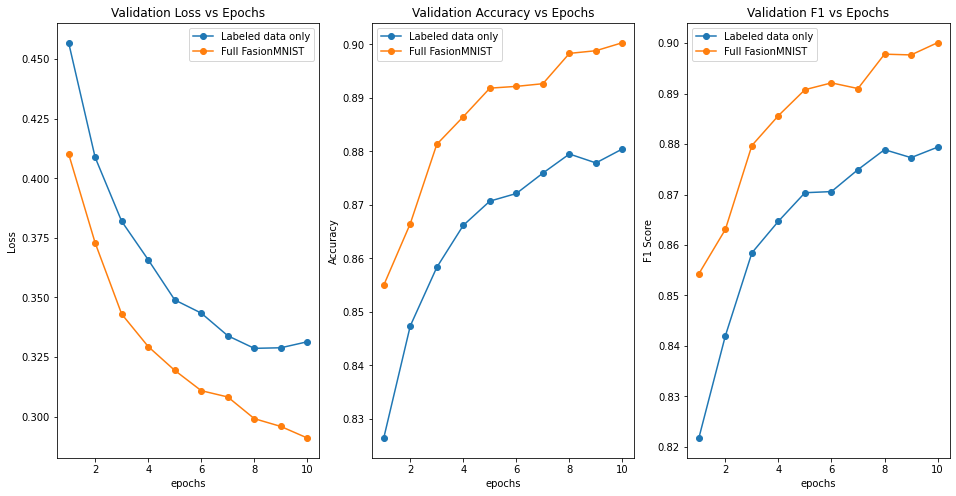

In [7]:
report_summary(mode_metrics, mode_description_short)

## Conclusion